In [1]:
import os
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import time
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU
import torch.optim as optimizers

import transformers
from transformers import AdamW
#from transformers import get_linear_schedule_with_warmup

#import torchtext
#from torchtext.data import get_tokenizer
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler, BatchSampler
import torchvision.transforms as transforms

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#set random seed
def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
set_seed(123)

In [4]:
# Easy data augmentation techniques for text classification
# Jason Wei and Kai Zou

import random
from random import shuffle


#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

#cleaning up text
import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

#for the first time you use wordnet
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

########################################################################
# main data augmentation function
########################################################################

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	
	sentence = get_only_chars(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not '']
	num_words = len(words)
	
	augmented_sentences = []
	num_new_per_technique = int(num_aug/4)+1
	n_sr = max(1, int(alpha_sr*num_words))
	n_ri = max(1, int(alpha_ri*num_words))
	n_rs = max(1, int(alpha_rs*num_words))

	#sr
	for _ in range(num_new_per_technique):
		a_words = synonym_replacement(words, n_sr)
		augmented_sentences.append(' '.join(a_words))

	#ri
	for _ in range(num_new_per_technique):
		a_words = random_insertion(words, n_ri)
		augmented_sentences.append(' '.join(a_words))

	#rs
	for _ in range(num_new_per_technique):
		a_words = random_swap(words, n_rs)
		augmented_sentences.append(' '.join(a_words))

	#rd
	for _ in range(num_new_per_technique):
		a_words = random_deletion(words, p_rd)
		augmented_sentences.append(' '.join(a_words))

	augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
	shuffle(augmented_sentences)

	#trim so that we have the desired number of augmented sentences
	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	#append the original sentence
	augmented_sentences.append(sentence)

	return augmented_sentences

In [5]:
#back_translator =  BackTranslator(back=True, undersampled=False, prob=1)

def expand_dataset(df, num_aug, balanced=True):
    aug_dict = {"id": [],
                "description": [],
               "jobflag": []}
    
    # weight to balance amount of data
    weight = [len(df[df.jobflag==n+1]) for n in range(len(df.jobflag.unique()))]
    
    for idx in tqdm(range(len(df))):
        
        if num_aug == 8:
            alpha_sr=0.05
            alpha_ri=0.05
            alpha_rs=0.05
            p_rd=0.05
        
        else:
            num_aug = 4
            alpha_sr=0.1
            alpha_ri=0.1
            alpha_rs=0.1
            p_rd=0.1
            
        if balanced:
            # weight to balance the amount of labels
            if df.jobflag.iloc[idx] == 1:
                num_aug = int(num_aug*weight[2-1]/weight[1-1])
            elif df.jobflag.iloc[idx] == 2:
                # standard
                num_aug = num_aug
            elif df.jobflag.iloc[idx] == 3:
                num_aug = int(num_aug*weight[2-1]/weight[3-1])
            elif df.jobflag.iloc[idx] == 4:
                num_aug = int(num_aug*weight[2-1]/weight[4-1])
            
            
        #Augmentation 
        aug = eda(df.description.iloc[idx], alpha_sr=alpha_sr, alpha_ri=alpha_ri, alpha_rs=alpha_rs, p_rd=p_rd, num_aug=num_aug)
        job = df.jobflag.iloc[idx]
        ids = df.id.iloc[idx]
        for n in range(len(aug)):
            aug_dict["id"].append(ids)
            aug_dict["description"].append(aug[n])
            aug_dict["jobflag"].append(job)
       
    print('now augmentation compleet !!')
            
    aug_df = pd.DataFrame(aug_dict)
    return aug_df

In [6]:
#read data_files
train = pd.read_csv('../input/signate-stcup-2020/train.csv')
test = pd.read_csv('../input/signate-stcup2020-new/test.csv')

In [7]:
job_dict = {1: "Data Scientist",2: "ML Engineer", 
            3: "Software Engineer",4: "Consultant"}
job_dict_init = {1:"DS",2:"MLEng",3:"SE",4:"Consul"}
num_classes = len(job_dict)
job_dict

{1: 'Data Scientist',
 2: 'ML Engineer',
 3: 'Software Engineer',
 4: 'Consultant'}

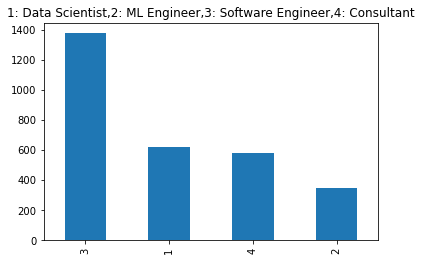

In [8]:
#visualize the data
plt.figure()
plt.title("1: Data Scientist,2: ML Engineer,3: Software Engineer,4: Consultant")
train.jobflag.value_counts().plot(kind="bar")

In [9]:
def get_reciprocal_freq(df):
    loss_weight = [len(df)/(4*len(df[df.jobflag==n+1])) for n in range(len(df.jobflag.unique()))]
    loss_weight = torch.tensor(loss_weight)
    return loss_weight

def get_freq(df):
    loss_weight = [(4*len(df[df.jobflag==n+1]))/len(df) for n in range(len(df.jobflag.unique()))]
    loss_weight = torch.tensor(loss_weight)
    return loss_weight

In [10]:
#define dataset
class Text_Dataset(Dataset):
    def __init__(self, csv_file, class_table=None, transform=None):
        self.csv_file = csv_file
        self.transform = transform
        self.class_table = class_table
        
        if self.csv_file.shape[1] >= 3:
            #train.shape=>(_,3)
            self.is_train = True
        else:
            #test.shape=>(_,2)
            self.is_train = False
    
    
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        
        if self.is_train:
            
            if self.class_table:
                if self.csv_file.jobflag.iloc[idx] == self.class_table:
                    label = torch.eye(2)[1]
                else:
                    label = torch.eye(2)[0]
            
            else:
                #label returns "jobflag" as onehot vector when you set csv_file="train"
                label = torch.eye(4)[int(self.csv_file.jobflag.iloc[idx])-1]
            
        else:
            #label returns the "id" when you set csv_file="test"
            label = self.csv_file.id.iloc[idx]
            
        text = self.csv_file.description.iloc[idx]
            
        if self.transform:
            text = self.transform(text)
        
        del idx
        return text, label

In [11]:
#define transform
class BERT_Tokenize(object):
    def __init__(self, model_type, max_len):
        self.max_len = max_len
        
        if model_type == "BERT" or model_type == "TAPTBERT":
            from transformers import BertTokenizer, BertForSequenceClassification
            self.bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
            
        elif model_type == "ALBERT":
            from transformers import AlbertTokenizer, AlbertForSequenceClassification
            self.bert_tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
            
        elif model_type == "XLNET":
            from transformers import XLNetTokenizer, XLNetForSequenceClassification
            self.bert_tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
        
        elif model_type == "ROBERTA":
            from transformers import RobertaTokenizer, RobertaForSequenceClassification
            self.bert_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
        
        elif model_type == "csROBERTA":
            from transformers import AutoTokenizer, AutoModel
            self.bert_tokenizer = AutoTokenizer.from_pretrained("allenai/cs_roberta_base")
            
        elif model_type == "XLMROBERTA":
            from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
            self.bert_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
            
        elif model_type == "ELECTRA":
            from transformers import ElectraTokenizer, ElectraForSequenceClassification
            self.bert_tokenizer = ElectraTokenizer.from_pretrained("google/electra-base-discriminator")
            
    
    def __call__(self,text):
        inputs = self.bert_tokenizer.encode_plus(
                        text,                       # Sentence to encode.
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = self.max_len,  # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,  # Construct attn. masks.
                   )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        del text, inputs
        return torch.LongTensor(ids), torch.LongTensor(mask)

text_dataset = Text_Dataset(csv_file=train,transform=None)
a, b = text_dataset[1]

In [12]:
#define BERT based model
class BERT_Net(nn.Module):
    def __init__(self, model_type, num_classes):
        super().__init__()
        
        self.model_type = True if model_type == "csROBERTA" or model_type == "TAPTBERT" else False
        
        if model_type == "ALBERT":
            from transformers import AlbertTokenizer, AlbertForSequenceClassification
            self.base_model = AlbertForSequenceClassification.from_pretrained(
                "albert-base-v2",early_stopping=False,num_labels=num_classes)
            
        elif model_type == "BERT":
            from transformers import BertTokenizer, BertForSequenceClassification
            self.base_model = BertForSequenceClassification.from_pretrained(
                "bert-base-cased",early_stopping=False,num_labels=num_classes)
            
        elif model_type == "XLNET":
            from transformers import XLNetTokenizer, XLNetForSequenceClassification
            self.base_model = XLNetForSequenceClassification.from_pretrained(
                "xlnet-base-cased",early_stopping=False,num_labels=num_classes)
            
        elif model_type == "ROBERTA":
            from transformers import RobertaTokenizer, RobertaForSequenceClassification
            self.base_model = RobertaForSequenceClassification.from_pretrained(
                "roberta-base",early_stopping=False,num_labels=num_classes)
            
        elif model_type == "csROBERTA":
            from transformers import AutoTokenizer, AutoModel
            self.base_model = AutoModel.from_pretrained("allenai/cs_roberta_base")
            self.classifier = nn.Sequential(
                nn.Linear(768, 768), nn.ReLU(), nn.Dropout(p=0.1),
                nn.Linear(768, 768), nn.ReLU(), nn.Dropout(p=0.1),
                nn.Linear(768, num_classes))
        
        elif model_type == "XLMROBERTA":
            from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
            self.base_model = XLMRobertaForSequenceClassification.from_pretrained(
                "xlm-roberta-base", num_labels=num_classes)
        
        elif model_type == "ELECTRA":
            from transformers import ElectraTokenizer, ElectraForSequenceClassification
            self.base_model = ElectraForSequenceClassification.from_pretrained(
                "google/electra-base-discriminator", num_labels=num_classes)
       
        elif model_type == "TAPTBERT":
            from transformers import AutoModel, AutoConfig
            config = AutoConfig.from_pretrained("../input/tapt-v2/config.json")
            self.base_model = AutoModel.from_pretrained("../input/tapt-v2/pytorch_model.bin", config=config)
            self.classifier = nn.Sequential(
                nn.Linear(768, 768), nn.ReLU(), nn.Dropout(p=0.1),
                nn.Linear(768, 768), nn.ReLU(), nn.Dropout(p=0.1),
                nn.Linear(768, num_classes))
    """
        for param in self.base_model.parameters():
            param.requires_grad = True
    """
    
    def forward(self, x):
        
        ids, mask = x
        
        if self.model_type:
            x = self.base_model(input_ids=ids, attention_mask=mask)
            x = self.classifier(x[1])
            preds = x
        else:
            x = self.base_model(input_ids=ids, attention_mask=mask, labels=None)
            preds = x[0]
            
        preds = nn.Softmax(dim=1)(preds)
        return preds

In [13]:
def model_config(model_type, max_len, num_classes):
    
    # define transforms and augmentation(back translation)
    transform = BERT_Tokenize(model_type=model_type,max_len=max_len)
        
    # define model
    model = BERT_Net(model_type=model_type,num_classes=num_classes)
    
    return transform, model

In [14]:
# Loss function and Optimizer configuration
def compute_loss(t, pred):
    if pred.shape[1] == 2:
        return F.binary_cross_entropy(pred,t,weight=torch.tensor([0.5,1.5]).to(device),size_average=None,reduce=None,reduction='mean')
    else:
        t = torch.argmax(t,dim=1)
        #loss_weight.to(device)
        return F.cross_entropy(pred,t,size_average=None,reduce=None,reduction='mean')

def compute_accuracy(t, pred):
    t, pred = t.to("cpu"), pred.to("cpu").detach().numpy()
    return sklearn.metrics.f1_score(t, pred, average='macro', sample_weight=None, zero_division='warn')


In [15]:
#train utils
def train_step(x, t, model, optimizer):
    preds = model(x)
    loss = compute_loss(t, preds)
    accuracy = compute_accuracy(torch.argmax(t,dim=1), torch.argmax(preds,dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()
    return loss, preds, accuracy

def val_step(x, t, model, optimizer):
    preds = model(x)
    loss = compute_loss(t, preds)
    accuracy = compute_accuracy(torch.argmax(t,dim=1), torch.argmax(preds,dim=1))
    return loss, preds, accuracy


#define EarlyStopping
class EarlyStopping:
    def __init__(self, patience=0, verbose=0, score_type="loss"):
        self._step = 0
        self.score_type = score_type
        if score_type == "loss":
            self._score = float('inf')
        elif score_type == "acc":
            self._score = -float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss, acc, epoch, model_dict, optim_dict, PATH):
        score = loss if self.score_type=="loss" else acc
        if self.score_check(score):
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._score = score
            torch.save({
            'epoch': epoch,
            'model_state_dict': model_dict,
            'optimizer_state_dict': optim_dict,
            'loss': loss,
            "accuracy": acc,
            }, PATH)
            print('Save check_point for "{}"'.format(PATH))
    
    def score_check(self,score):
        if self.score_type == "loss":
            return self._score < score
        elif self.score_type == "acc":
            return self._score > score

# define HistoryRecorder
class HistoryRecorder:
    def __init__(self, hist_type=2):
        self.hist_type = hist_type
        
        if self.hist_type ==1:
            self.hist = {'loss': [], 'val_loss': []}
        else:
            self.hist = {'loss': [], 'val_loss': [], "acc": [], "val_acc": []}
        
    def record(self, loss, val_loss, 
              acc=None, val_acc=None):
        
        self.hist["loss"].append(loss)
        self.hist["val_loss"].append(val_loss)
    
        if self.hist_type == 2:
            self.hist["acc"].append(acc)
            self.hist["val_acc"].append(val_acc)
        
    def hist(self):
        return self.hist

    
# visualizing function
def show_hist(loss=None, val_loss=None, acc=None, val_acc=None,
              hist=None, loss_type=None, acc_type=None):   
    if hist:
        loss = hist['loss']
        val_loss = hist['val_loss']
        acc = hist["acc"]
        val_acc = hist["val_acc"]
    
    plt.figure(figsize=(10,12))
    #visualize loss
    plt.subplot(2,1,1)
    plt.rc('font', family='serif')
    plt.plot(range(len(loss)), loss,
             color='blue', linewidth=1,
             label='train_loss')
    plt.plot(range(len(val_loss)), val_loss,
             color='red', linewidth=1,
             label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('loss (type = {})'.format(loss_type if loss_type else "None"))
    plt.legend()
    
    #visualize accurauy
    plt.subplot(2,1,2)
    plt.rc('font', family='serif')
    plt.plot(range(len(acc)), acc,
             color='blue', linewidth=1,
             label='train_acc')
    plt.plot(range(len(val_acc)), val_acc,
             color='red', linewidth=1,
             label='val_acc')
    plt.xlabel('epochs')
    plt.ylabel('accuracy (type = {})'.format(acc_type if acc_type else "None"))
    plt.legend()
    
    plt.show()

In [16]:
def RUN_TRAIN(train_dataloader, val_dataloader, model, optimizer, PATH, epochs=10, score_type="acc"):
    #training phase
    if __name__ == '__main__':

        es = EarlyStopping(patience=patience,verbose=1, score_type="loss")
        hist = HistoryRecorder(hist_type=2)

        model.to(device)
        for epoch in range(epochs):
            train_loss = 0.
            val_loss = 0.
            train_acc = 0.
            val_acc = 0.


            model.train()#####training phase#####
            for (x, t) in tqdm(train_dataloader):
                x[0], x[1] = x[0].to(device), x[1].to(device)
                t = t.to(device)
                loss, preds, accuracy = train_step(x, t, model, optimizer)
                train_loss += loss.detach().item()
                train_acc += accuracy
            train_loss /= len(train_dataloader)
            train_acc /= len(train_dataloader)


            model.eval()#####evaluation phase#####
            for (x, t) in tqdm(val_dataloader):
                x[0], x[1] = x[0].to(device), x[1].to(device)
                t = t.to(device)
                loss, preds, accuracy = val_step(x, t, model, optimizer)
                val_loss += loss.detach().item()
                val_acc += accuracy
            val_loss /= len(val_dataloader)
            val_acc /= len(val_dataloader)


            hist.record(train_loss,val_loss,train_acc,val_acc)
            print('epoch: {}, train_loss: {:.3}, val_loss:{:.3}, train_acc:{:.3}, val_acc:{:.3}'.format(
                    epoch+1, train_loss, val_loss, train_acc, val_acc))


            ##### EarlyStopping and save best scored check_point #####
            if es(loss=val_loss, acc=val_acc, epoch=epoch, 
                  model_dict=model.state_dict(), 
                  optim_dict=optimizer.state_dict(),
                  PATH=PATH
                 ):
                break


        ## visualize train_loss and val_loss ##
        show_hist(hist=hist.hist, loss_type="custom_CELoss", acc_type="F1_micro")

In [17]:
def add_weight_columns(df, base_df=None):
    if not base_df:
        base_df = df
    weight_list = get_reciprocal_freq(base_df).tolist()
    df["weight"] = [0]*len(df)
    for n in range(len(df)):
        df["weight"].iloc[n] = weight_list[int(df.jobflag.iloc[n])-1]
    return df

In [18]:
def RUN_Stratified_Nfold(csv_file, model_type, n_folds=5, class_table=None,
                         max_len=128, batch_size=16, num_workers=4, num_aug=4,
                         epochs=10, version="unknown", split_rate=0.8):
    
    #define model
    if class_table:
        num_classes = 2
        score_type = "loss"
        version = str(version) + "_class{}".format(class_table)
    else:
        num_classes = 4
        score_type = "loss"
    
    if n_folds != 0:
        
        #define StratifiedKFold
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2020)
        folds = 0
        
        for train_index, val_index in skf.split(csv_file, csv_file.jobflag):
            
            #make DataSubset
            train_subset = csv_file.iloc[train_index]
            val_subset = csv_file.iloc[val_index]
            
            # DataAugmentation
            if num_aug:
                print('now augmentation...')
                train_subset = expand_dataset(train_subset, num_aug, balanced=False)
                #val_subset = expand_dataset(val_subset, aug_type)
            
            train_subset = add_weight_columns(train_subset)
            val_subset = add_weight_columns(val_subset)
            train_sampler = BatchSampler(WeightedRandomSampler(train_subset.weight.tolist(), len(train_subset)//4, replacement=True), batch_size, drop_last=True)
            val_sampler = BatchSampler(WeightedRandomSampler(val_subset.weight.tolist(), len(val_subset), replacement=True), batch_size, drop_last=False)
            #define transformer (tokenizer and back_translator)
            transform, model = model_config(model_type=model_type, max_len=max_len, num_classes=num_classes)
            #define optimizer
            no_decay = ['bias', 'LayerNorm.weight']
            optimizer_grouped_parameters = [
                {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
            ]
            optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
            
            # define torch Dataset
            train_subset = Text_Dataset(csv_file=train_subset, 
                                        class_table=class_table, 
                                        transform=transform)
            val_subset = Text_Dataset(csv_file=val_subset, 
                                        class_table=class_table, 
                                        transform=transform)
            #make subset dataloader
            train_dataloader = DataLoader(train_subset, batch_sampler=train_sampler,
                                            num_workers=num_workers, pin_memory=True)

            val_dataloader = DataLoader(val_subset, batch_sampler=val_sampler,
                                            num_workers=num_workers, pin_memory=True)

            #PATH coonfig
            PATH = model_type + "_v{}".format(version) + "_" + str(folds) + ".pt"

            RUN_TRAIN(train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                     epochs=epochs, model=model, optimizer=optimizer, PATH=PATH)

            folds = folds + 1
            
            del model
            gc.collect()
        
        
    ### NOT kFold training ###
    elif n_folds == 0:
        
        # random split
        n_train = int(len(csv_file)*split_rate)
        n_val = len(csv_file) - n_train
        train_dataset, val_dataset = train_test_split(csv_file, train_size=n_train, test_size=n_val)
        
        # DataAugmentation
        if num_aug:
            print('now augmentation...')
            train_dataset = expand_dataset(train_dataset, num_aug, balanced=False)
            #val_dataset = expand_dataset(val_dataset, aug_type)
        
        train_dataset = add_weight_columns(train_dataset)
        val_dataset = add_weight_columns(val_dataset)
        train_sampler = BatchSampler(WeightedRandomSampler(train_dataset.weight.tolist(), len(train_dataset)//4, replacement=True), batch_size, drop_last=True)
        val_sampler = BatchSampler(WeightedRandomSampler(val_dataset.weight.tolist(), len(val_dataset), replacement=True), batch_size, drop_last=False)
        #define transformer (tokenizer and back_translator)
        transform, model = model_config(model_type=model_type, max_len=max_len, num_classes=num_classes)
        #define optimizer
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
                {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
        
        # define torch Dataset
        train_dataset = Text_Dataset(csv_file=train_dataset, 
                                        class_table=class_table, 
                                        transform=transform)
        val_dataset = Text_Dataset(csv_file=val_dataset, 
                                        class_table=class_table, 
                                        transform=transform)
        # Dataloader
        train_dataloader = train_dataloader = DataLoader(train_dataset,batch_sampler=train_sampler,
                                                         num_workers=num_workers, pin_memory=True)
        
        val_dataloader = val_dataloader = DataLoader(val_dataset, batch_sampler=val_sampler,
                                                     num_workers=num_workers, pin_memory=True)
        
        PATH = model_type + "_v{}".format(version) + ".pt"
        
        RUN_TRAIN(train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                     epochs=epochs, model=model, optimizer=optimizer, PATH=PATH, score_type=score_type)

In [19]:
def RUN_for_augmented_dataset(csv_files, model_type, n_folds=5, class_table=None,
                         max_len=128, batch_size=16, num_workers=4, num_aug=4,
                         epochs=10, version="unknown", split_rate=0.8):
    #define model
    if class_table:
        num_classes = 2
        score_type = "loss"
        version = str(version) + "_class{}".format(class_table)
    else:
        num_classes = 4
        score_type = "loss"
    
    
    for fold, datasets in enumerate(csv_files):
        train_dataset, val_dataset = datasets
        
        #define transformer (tokenizer and back_translator)
        transform, model = model_config(model_type=model_type, max_len=max_len, num_classes=num_classes)
        #define optimizer
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
            
        # DataAugmentation
        if num_aug:
            print('now EDA augmentation...')
            train_dataset = expand_dataset(train_dataset, num_aug)
            #val_dataset = expand_dataset(val_dataset, aug_type)

        train_dataset = add_weight_columns(train_dataset)
        val_dataset = add_weight_columns(val_dataset)
        train_sampler = BatchSampler(WeightedRandomSampler(train_dataset.weight.tolist(), len(train_dataset)//8, replacement=True), batch_size, drop_last=True)
        val_sampler = BatchSampler(WeightedRandomSampler(val_dataset.weight.tolist(), len(val_dataset), replacement=True), batch_size, drop_last=False)
        # define torch Dataset
        train_dataset = Text_Dataset(csv_file=train_dataset, 
                                        class_table=class_table, 
                                        transform=transform)
        val_dataset = Text_Dataset(csv_file=val_dataset, 
                                        class_table=class_table, 
                                        transform=transform)
        # Dataloader
        train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler,
                                        num_workers=num_workers, pin_memory=True,)
        
        val_dataloader = DataLoader(val_dataset, batch_sampler=val_sampler,
                                        num_workers=num_workers, pin_memory=True, )
        
        PATH = model_type + "_v{}".format(version) + "_" + str(fold) + ".pt"
        
        RUN_TRAIN(train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                     epochs=epochs, model=model, optimizer=optimizer, PATH=PATH, score_type=score_type)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# Early_Stopping configuration
patience = 1

In [22]:
def make_df_by_paths(paths):
    dfs = pd.DataFrame([])
    for path in paths:
        df = pd.read_csv(path)
        dfs = pd.concat([dfs.dropna(),df], axis=0, join='outer')
    train_bt = dfs.dropna()
    return train_bt

In [23]:
languages = ['bg', 'de', 'ar', 'hi', 'sw', 'vi', 'es', 'el']
#paths = [f"../input/bt-augmented-x8/stcup2020-train-google-{LANG}-balanced.csv" for LANG in languages]

#val = pd.read_csv('../input/bt-augmented-x8/stcup2020-val.csv')
#val.dropna()

#train_bt = make_df_by_paths(paths)

#plt.figure()
#plt.title("augmented data\n1: Data Scientist,2: ML Engineer,3: Software Engineer,4: Consultant")
#train_bt.jobflag.value_counts().plot(kind="bar")

path_1 = [f'../input/paseudo98-1/stcup2020-train-pseudo-google-{LANG}-fold1.csv' for LANG in languages]
path_2 = [f'../input/paseudo98-1/stcup2020-train-pseudo-google-{LANG}-fold2.csv' for LANG in languages]
path_3 = [f'../input/paseudo98-1/stcup2020-train-pseudo-google-{LANG}-fold3.csv' for LANG in languages]

fold_1 = make_df_by_paths(path_1)
val_1 = pd.read_csv('../input/paseudo98-1/stcup2020-val-pseudo-google-fold1.csv')
fold_2 = make_df_by_paths(path_2)
val_2 = pd.read_csv('../input/paseudo98-1/stcup2020-val-pseudo-google-fold2.csv')
fold_3 = make_df_by_paths(path_3)
val_3 = pd.read_csv('../input/paseudo98-1/stcup2020-val-pseudo-google-fold3.csv')

In [24]:
path_1 = [f'../input/pseudo-987/stcup2020-train-pseudo-google-{LANG}-fold1.csv' for LANG in languages]
path_2 = [f'../input/pseudo-987/stcup2020-train-pseudo-google-{LANG}-fold2.csv' for LANG in languages]
path_3 = [f'../input/pseudo-987/stcup2020-train-pseudo-google-{LANG}-fold3.csv' for LANG in languages]

fold_1 = make_df_by_paths(path_1)
val_1 = pd.read_csv('../input/pseudo-987/stcup2020-val-pseudo-google-fold1.csv')
fold_2 = make_df_by_paths(path_2)
val_2 = pd.read_csv('../input/pseudo-987/stcup2020-val-pseudo-google-fold2.csv')
fold_3 = make_df_by_paths(path_3)
val_3 = pd.read_csv('../input/pseudo-987/stcup2020-val-pseudo-google-fold3.csv')

In [25]:
##### training configuration #####

# number of folds for stratifiedKfold
# if you want to not use skf, you can chose "nfolds=0"
n_folds = 3
csv_files = [(fold_1, val_1), (fold_2, val_2), (fold_3, val_3)]

# EDA augmentation size => 4 or None
num_aug = None

#training model => ["BERT", "ALBERT", "XLNET", "ROBERTA"]
model_type = "ROBERTA"
class_table = None
version = 40 # version will used for PATH{="model_type" + "_v" + str(version) + "x-folds"(n_folds > 1)}
                # example: "ALBERT_v1_0", "XLNET_v4_4"
max_len = 128

###
batch_size = 32
num_workers = 4
epochs = 15

100%|██████████| 35/35 [00:04<00:00,  7.76it/s]


epoch: 1, train_loss: 1.38, val_loss:1.33, train_acc:0.169, val_acc:0.296


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_0.pt"


100%|██████████| 35/35 [00:04<00:00,  7.75it/s]


epoch: 2, train_loss: 1.19, val_loss:1.1, train_acc:0.529, val_acc:0.624


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_0.pt"


100%|██████████| 35/35 [00:04<00:00,  7.73it/s]


epoch: 3, train_loss: 1.09, val_loss:1.09, train_acc:0.639, val_acc:0.62


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_0.pt"


100%|██████████| 35/35 [00:04<00:00,  7.73it/s]


epoch: 4, train_loss: 1.06, val_loss:1.09, train_acc:0.67, val_acc:0.619


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_0.pt"


100%|██████████| 35/35 [00:04<00:00,  7.74it/s]


epoch: 5, train_loss: 1.06, val_loss:1.09, train_acc:0.664, val_acc:0.618


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_0.pt"


  0%|          | 0/69 [00:00<?, ?it/s]

epoch: 6, train_loss: 1.01, val_loss:1.1, train_acc:0.729, val_acc:0.601


100%|██████████| 35/35 [00:04<00:00,  7.70it/s]


epoch: 7, train_loss: 1.02, val_loss:1.07, train_acc:0.706, val_acc:0.66


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_0.pt"


  0%|          | 0/69 [00:00<?, ?it/s]

epoch: 8, train_loss: 0.999, val_loss:1.1, train_acc:0.726, val_acc:0.629


100%|██████████| 35/35 [00:04<00:00,  7.73it/s]


epoch: 9, train_loss: 0.983, val_loss:1.06, train_acc:0.749, val_acc:0.651


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_0.pt"


  0%|          | 0/69 [00:00<?, ?it/s]

epoch: 10, train_loss: 0.985, val_loss:1.11, train_acc:0.749, val_acc:0.6


100%|██████████| 35/35 [00:04<00:00,  7.71it/s]


epoch: 11, train_loss: 0.967, val_loss:1.07, train_acc:0.76, val_acc:0.657
early stopping


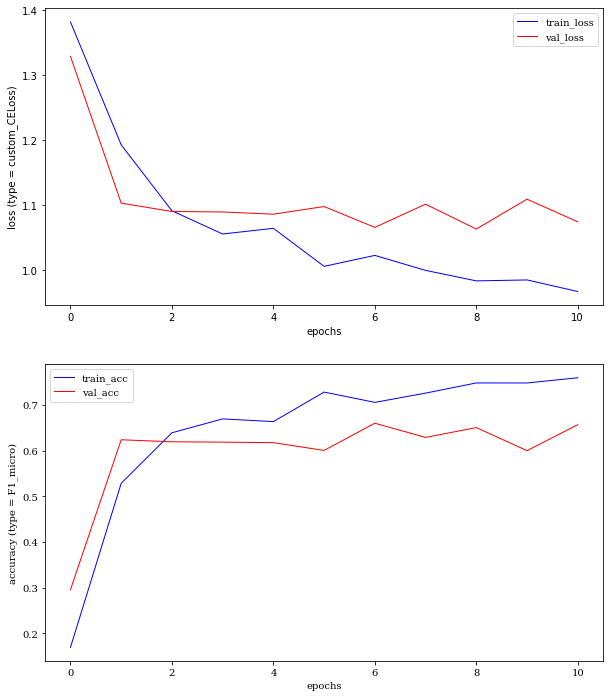

100%|██████████| 35/35 [00:04<00:00,  7.58it/s]


epoch: 1, train_loss: 1.38, val_loss:1.31, train_acc:0.252, val_acc:0.433


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_1.pt"


100%|██████████| 35/35 [00:04<00:00,  7.62it/s]


epoch: 2, train_loss: 1.18, val_loss:1.14, train_acc:0.546, val_acc:0.599


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_1.pt"


100%|██████████| 35/35 [00:04<00:00,  7.63it/s]


epoch: 3, train_loss: 1.11, val_loss:1.12, train_acc:0.613, val_acc:0.609


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_1.pt"


100%|██████████| 35/35 [00:04<00:00,  7.53it/s]


epoch: 4, train_loss: 1.08, val_loss:1.12, train_acc:0.646, val_acc:0.597


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_1.pt"


100%|██████████| 35/35 [00:04<00:00,  7.63it/s]


epoch: 5, train_loss: 1.05, val_loss:1.09, train_acc:0.675, val_acc:0.629


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_1.pt"


  0%|          | 0/69 [00:00<?, ?it/s]

epoch: 6, train_loss: 1.03, val_loss:1.09, train_acc:0.703, val_acc:0.625


100%|██████████| 35/35 [00:04<00:00,  7.54it/s]


epoch: 7, train_loss: 1.02, val_loss:1.1, train_acc:0.709, val_acc:0.614
early stopping


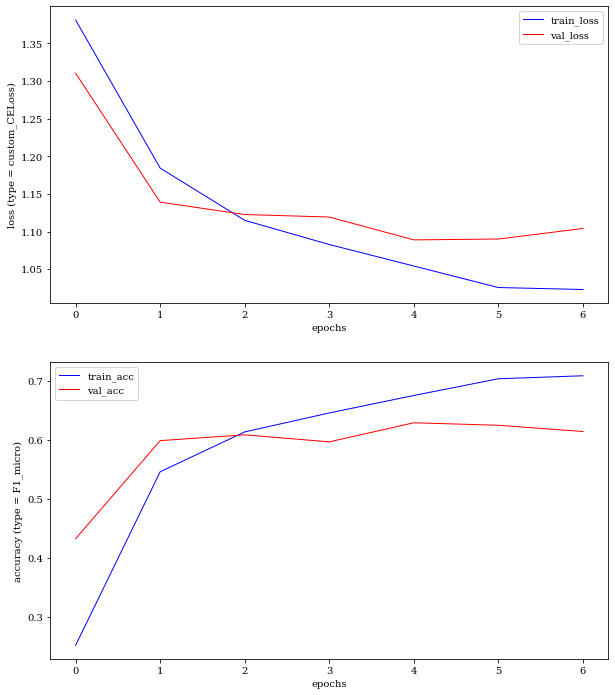

100%|██████████| 35/35 [00:04<00:00,  7.53it/s]


epoch: 1, train_loss: 1.38, val_loss:1.34, train_acc:0.166, val_acc:0.25


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_2.pt"


100%|██████████| 35/35 [00:04<00:00,  7.29it/s]


epoch: 2, train_loss: 1.19, val_loss:1.11, train_acc:0.549, val_acc:0.628


  0%|          | 0/69 [00:00<?, ?it/s]

Save check_point for "ROBERTA_v40_2.pt"


  0%|          | 0/69 [00:00<?, ?it/s]

epoch: 3, train_loss: 1.1, val_loss:1.13, train_acc:0.638, val_acc:0.595


100%|██████████| 35/35 [00:04<00:00,  7.34it/s]


epoch: 4, train_loss: 1.06, val_loss:1.12, train_acc:0.668, val_acc:0.6
early stopping


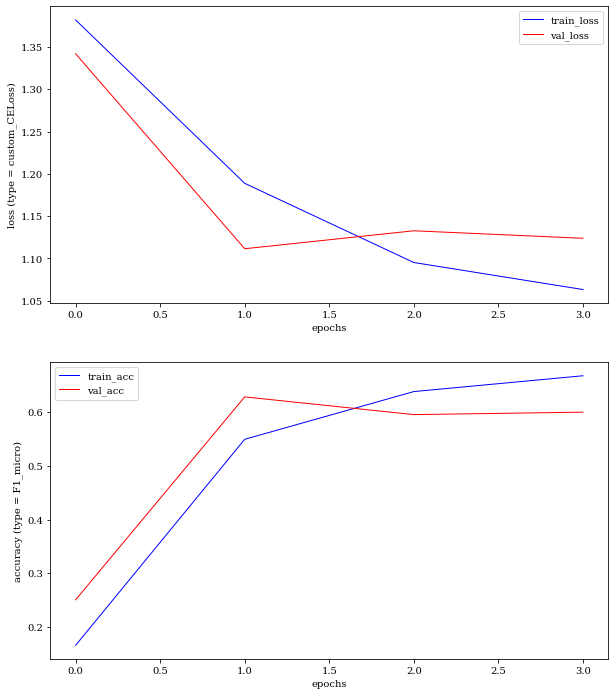

In [26]:

RUN_for_augmented_dataset(n_folds=n_folds, csv_files=csv_files, model_type=model_type,
                         max_len=max_len, class_table=class_table,
                     batch_size=batch_size, num_workers=num_workers,
                         epochs=epochs, version=version, num_aug=num_aug)



RUN_Stratified_Nfold(n_folds=n_folds, csv_file=csv_files, model_type=model_type,
                         max_len=max_len, class_table=class_table,
                     batch_size=batch_size, num_workers=num_workers,
                         epochs=epochs, version=version, num_aug=num_aug)
